# **Fake And Real News Classification**

---

Authors: [Femi Kamau](https://www.github.com/ctrl-Karugu), [Monicah Iwagit](), [Teofilo Gafna](), [Wendy Mwiti](https://www.github.com/WendyMwiti)

## 1. Business Understanding

## 1.1 Determine Business Objectives
## 1.1.1 Background
In recent decades, the prevalence of fake news in the media has gradually increased. The term "fake news" refers to news, information, or stories that are either wholly made up or inaccurate to some degree and are created to either influence people’s views, push a political agenda or cause confusion. 

According to a survey carried out by Edelman Public Relations Firm, media trust has consistently dropped by 8% every year. There exists a general lack of confidence in whatever information is disseminated by the media with a percentage as high as 41% of people actively saying that they avoid the news.

In the past, we relied on reliable journalists, media organizations, and sources who were bound by stringent ethical standards. However, the internet has made it possible to publish, exchange, and consume news and information in a completely new way with hardly any restrictions or editorial guidelines.

Nowadays, a lot of people obtain their news from social media networks and websites, and it can frequently be challenging to determine whether a story is legitimate or not. Any surge in false news or hoax stories has also been attributed to information overload and a general lack of understanding by individuals of how the internet functions.
Hence the need for our project -the building of an NLP based classifier that categorizes articles on  whether they are real or fake. 

## 1.1.2 Problem Statement
Fake news has various effects on human life, some of which are surprising and could vary from the way we humans perceive risk, the content of our dreams and even to our likelihood of getting a health complication. Therefore, this project, in a bid to reduce some of these effects, is concerned with identifying a solution that could be used to detect and filter out articles containing fake news as it will prove  useful to both readers and companies (stakeholders of the project) interested in the issue.

## 1.1.3 Research Questions
* Which periods of the year have the most fake news?
* Which person appears most in fake news?
* What topics are most prevalent in fake news?
* What are the most common keywords in fake news?

## 1.1.4 Business Objectives
* To establish which months have the most fake news.
* To ascertain which subject dominated the fake news.
* To  predict if news is fake or real

## 1.1.5 Business Success Criteria
Build an NLP Classification model that predicts, with an accuracy of 90%, the validity of the news articles and a precision of 90% 


## 2. Data Understanding

Load Libraries

In [221]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
import nltk
import nltk
import re
from nltk.corpus import stopwords
from nltk.collocations import *
import string
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, auc, RocCurveDisplay
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn import svm
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error
import pickle
import spacy
import unidecode
from word2number import w2n
import contractions
import re


nlp = spacy.load('en_core_web_sm')

# Remove 'no' and 'not' from SpaCy's stop words list
deselect_stop_words = ['no', 'not']
for w in deselect_stop_words:
    nlp.vocab[w].is_stop = False
    
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Wendy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


We had 2 csv files sourced from kaggle which contains nearly 23481 fake news and 21417 real news posted between 2015-2018 from news sites such as 21st Century Wire


Load Data

In [222]:
# Load the real news data
real = pd.read_csv('./data/True.csv')

# Load the fake news data
fake = pd.read_csv('./data/Fake.csv')

In [223]:
# Preview real data
real.head(2)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   
1  U.S. military to accept transgender recruits on Monday: Pentagon   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [224]:
# Preview the fake data
fake.head(2)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing,"Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and the very dishonest fake news media. The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year, President Angry Pants tweeted. 2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America! Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year! Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress. Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me? Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish?? Marlene (@marlene399) December 31, 2017You can t just say happy new year? Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love! Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his enemies and haters for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President? Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down. Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters? Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.",News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian Collusion Investigation,"House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being a drunken fool in a wine bar. Coffee boys don t help to arrange a New York meeting between Trump and President Abdel Fattah el-Sisi of Egypt two months before the election. It was known before th

In [225]:
#  Add a column called 'category' to both DataFrames which will become our taget variable
real['category'] = 1
fake['category'] = 0

In [226]:
# Combine both DataFrames 
data = pd.concat([real, fake])

In [227]:
# Preview the new DataFrame head
data.head(2)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   
1  U.S. military to accept transgender recruits on Monday: Pentagon   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [228]:
# Preview the new DataFrame tail
data.tail(2)

title  \
23479                How to Blow $700 Million: Al Jazeera America Finally Calls it Quits   
23480  10 U.S. Navy Sailors Held by Iranian Military – Signs of a Neocon Political Stunt   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

### Description of columns in the file:

`title`- contains news headlines

`text`- contains news content/article

`subject`- the type of news

`date`- the date the news was published


In [229]:
class dataUnderstanding(object):
    """A class that does basic Data Understanding"""
    
    def __init__(self, df):
        self.shape = df.shape
        self.info = df.info
        self.duplicates = df.duplicated().sum()
        self.missing = df.isna().sum()
        self.types = df.dtypes

In [230]:
# Instantiate the class
understanding = dataUnderstanding(data)

In [231]:
# Summary of the dataset
print(f"Shape:{understanding.shape}")
print()
print(understanding.info())

Shape:(44898, 5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44898 non-null  object
 1   text      44898 non-null  object
 2   subject   44898 non-null  object
 3   date      44898 non-null  object
 4   category  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB
None


From the summary above, we can see that the dataset contain 44898 rows and spans 5 columns. The columns are: title, text, subject, date and category. The category column is the target variable and the rest are the features.

Furthermore, the dataset contains 4 object columns and 1 integer column. The object columns are: title, text, subject and date. The integer column is: category (target variable). We may need to convert the date column to datetime format in the data preparation phase.

The dataset does not contain any missing values.

In [232]:
# Check for duplicates
print(f"Duplicates: {understanding.duplicates}")

Duplicates: 209


The dataset contains 209 duplicates. They shall be inspected and removed if necessary in the data preparation phase.

In [233]:
# Check the number of missing values
understanding.missing

title       0
text        0
subject     0
date        0
category    0
dtype: int64

In [234]:
# Inspect the value counts in the subject column
data['category'].value_counts()

0    23481
1    21417
Name: category, dtype: int64

The articles that are within this dataset fall under 8 different subjects. These are: politicsNews, worldnews, News, politics, left-news, Government News, US_News, and Middle-east.

In [235]:
# Inspect the value counts in the category column
data['category'].value_counts()

0    23481
1    21417
Name: category, dtype: int64

The dataset is fairly balanced between fake and real news 

In [236]:
# Inspect the date column
data['date'].nunique()

2397

The date column contains 2397 unique dates

## 3. Data Preparation


### 3.1 Validity

> To ensure validity within the dataset, we will be checking that the data is in the correct format.

In [237]:
# Converting the subject column to category
data['subject'] = data['subject'].astype('category')

In [238]:
# Converting date from object to datetime
data['date'] = pd.to_datetime(data['date'], dayfirst=True, errors='coerce')

# Type of the date column
data['date'].dtype

# Preview the updated DataFrame 
data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [239]:
# Extract the months and the years from the date column
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.strftime('%B')

In [240]:
# Inspect the updated datatypes
data.dtypes

title               object
text                object
subject           category
date        datetime64[ns]
category             int64
year               float64
month               object
dtype: object

### 3.2 Consistency

> In this section, we will be obeserving the consistency of the data. We will be checking for duplicates

In [241]:
# Create a dataframe for the duplicated to be inspected
duplicates  = data[data.duplicated()]
duplicates.head(3)

title  \
445        Senate tax bill stalls on deficit-focused 'trigger'   
778     Trump warns 'rogue regime' North Korea of grave danger   
892  Republicans unveil tax cut bill, but the hard work awaits   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [242]:
# Drop the duplicates
print(f"Before dropping: {len(data)}")
data.drop_duplicates(inplace=True)
print(f"After dropping: {len(data)}")

Before dropping: 44898
After dropping: 44689


Remove the URLS from the text column

### 3.3 Completeness

From data understanding section we found there to be no missing values. Therefore we can confirm that the the dataset is complete.

### 3.4 Uniformity

 To check on whether different systems refer to the same value in the same format

In [243]:
# Check the value counts of the subject column
data['subject'].value_counts()

politicsNews       11220
worldnews           9991
News                9050
politics            6838
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [244]:
# Rename the categories in the subject column
data['subject'].replace({'politicsNews': 'politics',
                         'worldnews': 'world_news',
                         'News': 'news',
                         'left-news': 'left_news',
                         'Government News': 'government_news',
                         'US_News': 'us_news',
                         'Middle-east': 'middle_east'}, inplace=True)


In [245]:
# Preview the updated subject column value counts
data['subject'].value_counts()

politics           18058
world_news          9991
news                9050
left_news           4459
government_news     1570
us_news              783
middle_east          778
Name: subject, dtype: int64

### 3.5 Exploratory Data Analysis

#### 3.5.1 Univariate Analysis

In [246]:
# Create a function that visualizes the value counts of a column
def plot_bar(df, col)-> None:
    """ A function that returns a plot count of columns"""
    plt.figure(figsize=(12,8))
    sns.countplot(data=df, x = col, order=df[col].value_counts().index)
    plt.title(f"{col} count plot", fontsize=25)
    plt.ylabel("Count", fontsize=15)
    plt.xticks(rotation=45)
    plt.xlabel(f"{col}", fontsize=15)
    plt.show()
    

##### 3.5.1.1 `text`

In [247]:
def plot_word_cloud(df, target, feature, i:int):
    """This fuction creates a wordcloud for the news texts"""
    real_news =df[df[target]==i]
    text = data[feature].values
    wordcloud = WordCloud(
        max_words = 400,
        width = 800,
        height = 600,
        background_color = 'black',
        stopwords = STOPWORDS).generate(str(text))
    fig = plt.figure(
        figsize = (14, 8),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

##### Fake News Visualization Word Cloud

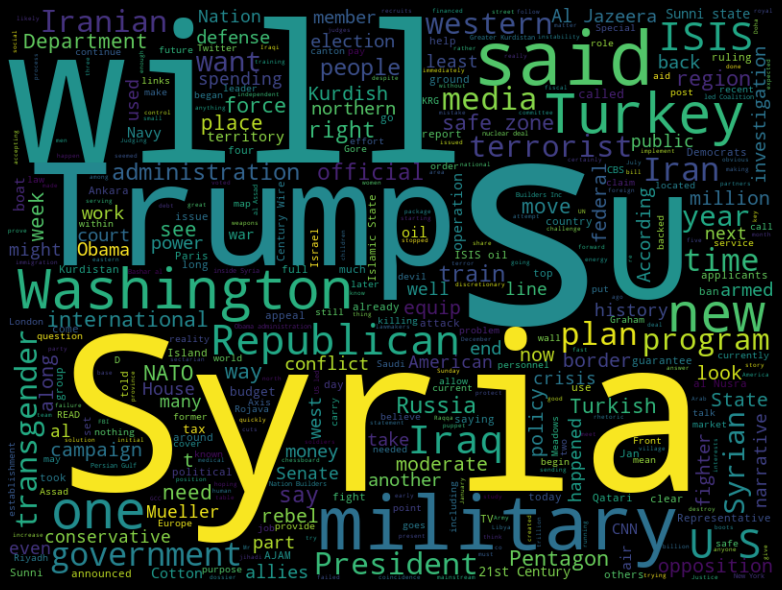

In [248]:
plot_word_cloud(data, 'category', 'text', 0)

##### Real News Visualization Word Cloud

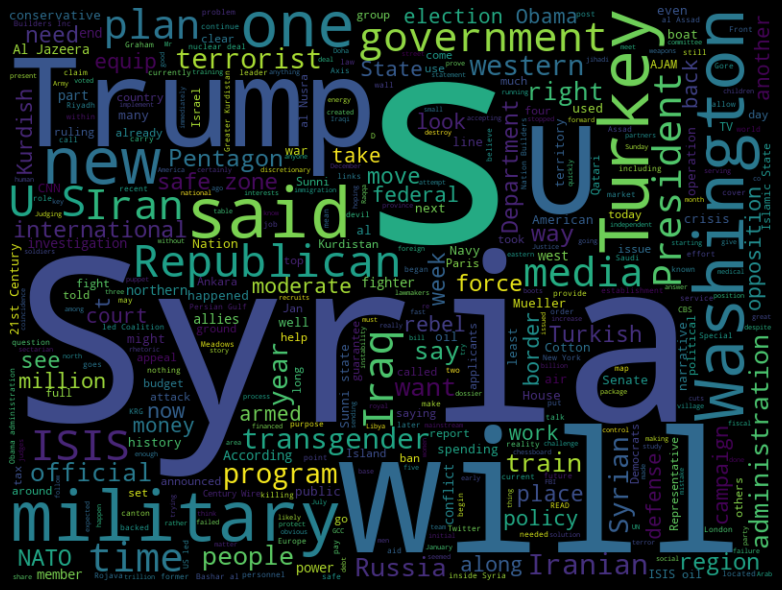

In [249]:
plot_word_cloud(data, 'category', 'text', 1)

##### 3.5.1.2 `subject`

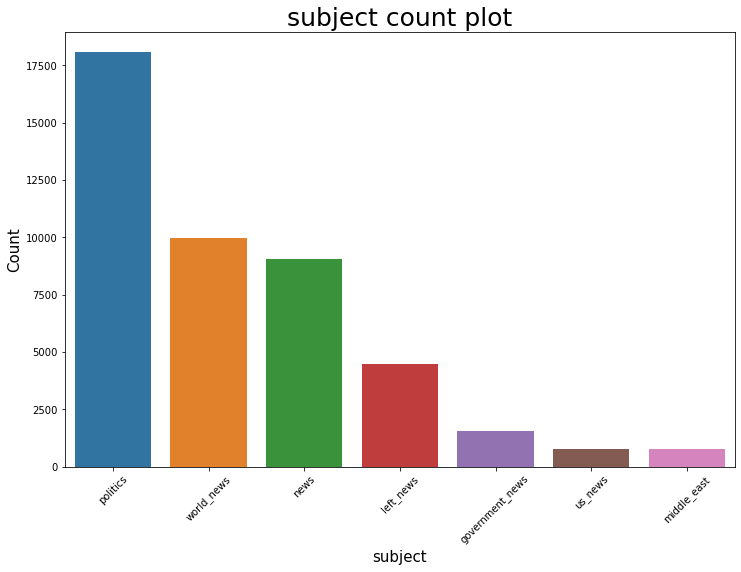

In [250]:
# Plotting a countplot of the subject
plot_bar(data, 'subject')

Observations:
* Most of the published news talk about politics followed by world news while the least discussed subject is the Middle East

##### 3.5.1.3 `month`

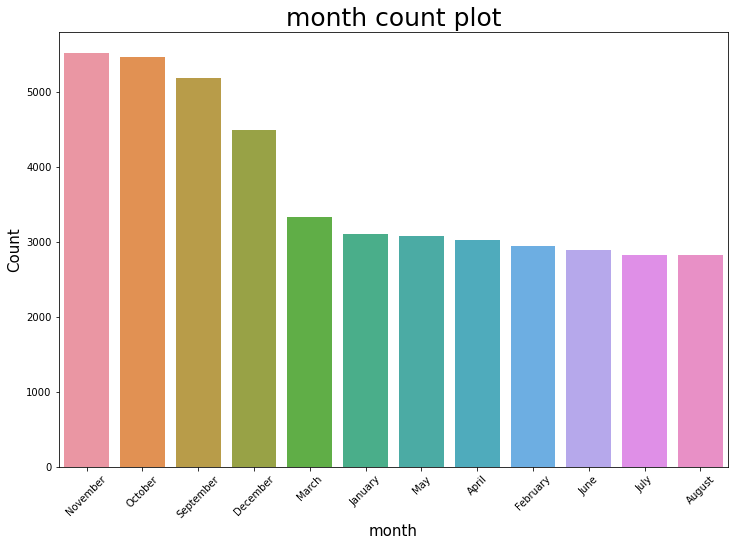

In [251]:
# Plotting a countplot of the Months
plot_bar(data, 'month')

Observations:
* Most of the news is published during the month of November followed by October and September.
* It is also worth noting that the months of September and October precede November.
* The month of August registered the least number of published news

##### 3.5.1.4 `year`

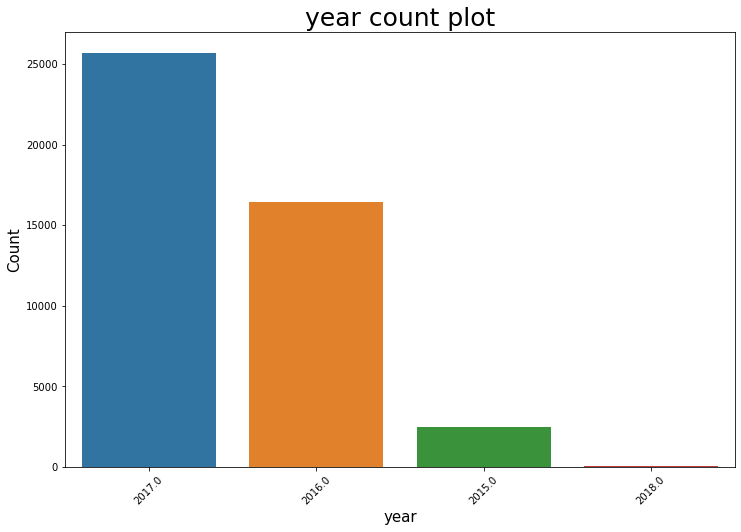

In [252]:
# Plotting the years
plot_bar(data, 'year')

Observations:
* 2017 had the most news followed by 2016

##### 3.5.1.5 `category`

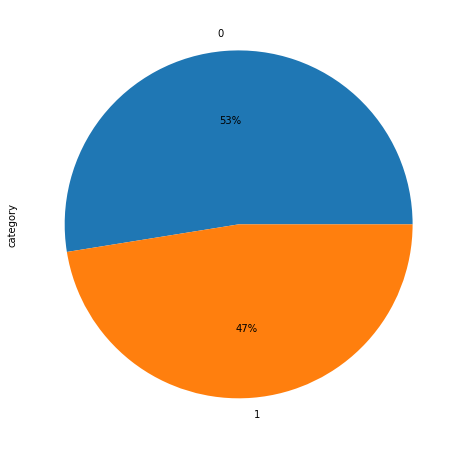

In [253]:
# Plotting a pie chart for the column 'category'
fig, ax = plt.subplots(figsize=(12,8))
data['category'].value_counts().plot(kind='pie', autopct='%.0f%%');

Observations:
* The data set is fairly balanced. However, fake news is slightly more than real news.

#### 3.5.2 Bivariate Analysis

In [254]:
# Creating a function that plots a count plot with respect to another column
def plot_bivariate(df, col, by):
    plt.figure(figsize=(12,8))
    sns.countplot(data=df, x=col, hue=by)
    plt.title(f"{col} count plot by {by}", fontsize=25)
    plt.ylabel("count", fontsize=15)
    plt.xticks(rotation=45)
    plt.xlabel(f"{col}", fontsize=15)
    plt.show()

##### 3.5.2.1 `month` & `category`

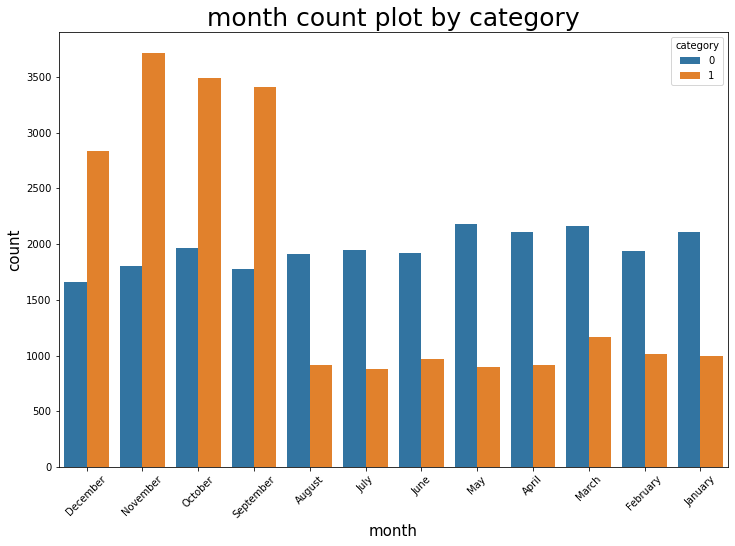

In [255]:
# Plotting month by category
plot_bivariate(data, 'month', 'category')

Observations:
  * From the visualization above, we see a spike in real news towards the end of the year. However, fake news remains constant throughout the year. 

##### 3.5.2.2 `year` & `category`

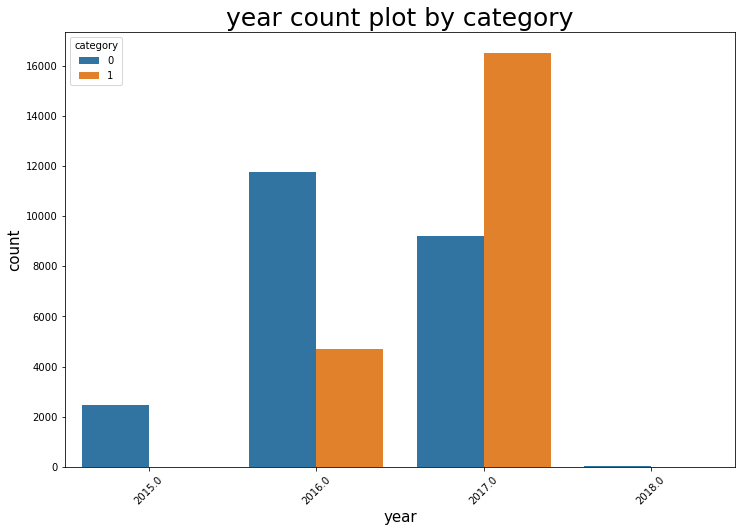

In [256]:
# plot year by category
plot_bivariate(data, 'year', 'category')

Observations:
* The visualization above tells us that majority of the news captured in this dataset is from the year 2016 and 2017. Furthermore, 2017 seems to have a higher amount of data output compared to the rest. This could be attributed to the fact that 2017 was the beginning of a new presidential term in the United States which always brings with it a fair share of news coverage.

##### 3.5.2.3 `subject` & `category`

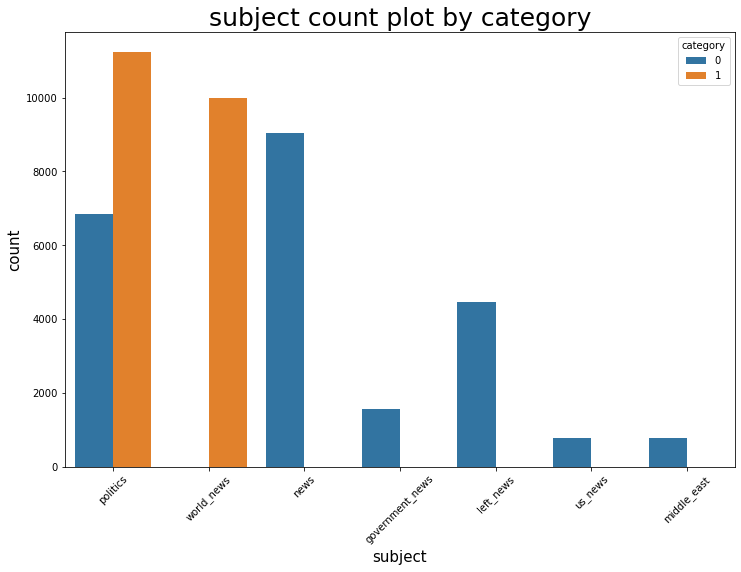

In [257]:
plot_bivariate(data, 'subject', 'category')

Observations
* We see that the real news within this dataset falls under the politics nad world_news subjects. Therefore, a prediction system would probably work best for the aforementioned subjects.

## 4. Modeling

### 4.1 Data Preprocessing

In [258]:
# A function to remove web tags
def remove_web_tags(text):
    """Remove html tags from a string"""
    # Remove https links
    clean = re.compile(r'https\S*')
    text = re.sub(clean, '', text)

    # Remove data '.com' links
    clean = re.compile(r'\S+\.com\S+')
    return re.sub(clean, '', text)


# Function to remove twitter handles
def remove_twitter_handles(text):
    """This function removes twitter handles from a string"""
    clean = re.compile(r'@\S*')
    return re.sub(clean, '', text)


# Function to convert Non-ASCII characters to ASCII
def remove_accented_chars(text):
    """This function removes accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text


# Function to expand contractions
def expand_contractions(text):
    """Expand shortened words, e.g. don't to do not"""
    text = contractions.fix(text)
    return text


# Function to remove special characters
def remove_special_characters(text):
    """This function removes special characters from text, e.g. $"""
    clean = re.compile(r'[^a-zA-Z0-9\s]')
    return re.sub(clean, ' ', text)


# Function to lowercase text
def lowercase_text(text):
    """This function converts characters to lowercase"""
    return text.lower()


# Function to convert number words to digits
def convert_number_words(text):
    """Convert number words to digits and remove them"""
    
    pattern = r'(\W+)'
    tokens = re.split(pattern, text)

    for i, token in enumerate(tokens):
        try:
            tokens[i] = str(w2n.word_to_num(token))
        except:
            pass
    
    return ''.join(tokens)


# Function to remove numbers
def remove_numbers(text):
    """This function removes numbers from text"""
    clean = re.compile(r'\d+')
    return re.sub(clean, '', text)


# Function to remove short words
def remove_small_words(text):
    """This function removes words with length 1 or 2"""
    clean = re.compile(r'\b\w{1,2}\b')
    return re.sub(clean, '', text)


# Function to remove names of people
def remove_names(text):
    """This is a function that removes the names from text"""
    with open('./data_preprocessing/names.txt', 'r') as f:
        NAMES = set(f.read().splitlines())

        NAMES = [name.lower() for name in NAMES]
        
    pattern = r'\W+'
    tokens = re.split(pattern, text)
    
    words = tokens
      
    for token in tokens:
        if token in NAMES:
            while token in words:
                words.remove(token)
    
    text = ' '.join(words)
    
    return text


# Function to remove countries
def remove_countries(text):
    """This is a function that removes the countries from text"""
    with open('./data_preprocessing/countries.txt', 'r') as f:
        COUNTRIES = set(f.read().splitlines())

        COUNTRIES = [name.lower() for name in COUNTRIES]
        
    pattern = r'(\W+)'
    tokens = re.split(pattern, text)
    
    words = tokens
    
    for token in tokens:
        if token in COUNTRIES:
            while token in words:
                words.remove(token)
    
    text = ' '.join(words)
    
    return text


# Function to remove US cities of people
def remove_cities(text):
    """This is a function that removes the US cities from text"""
    with open('./data_preprocessing/cities.txt', 'r') as f:
        CITIES = set(f.read().splitlines())

        CITIES = [name.lower() for name in CITIES]
        
    pattern = r'(\W+)'
    tokens = re.split(pattern, text)
    
    words = tokens
    
    for token in tokens:
        if token in CITIES:
            while token in words:
                words.remove(token)
    
    text = ' '.join(words)
    
    return text


# Function to remove days and months
def remove_days_and_months(text):
    """This is a function that removes the months and years from text"""
    
    # Load the months
    with open('./data_preprocessing/months.txt', 'r') as f:
        MONTHS = set(f.read().splitlines())

        MONTHS = [name.lower() for name in MONTHS]
    
    # Load the days of the week
    with open('./data_preprocessing/week.txt', 'r') as f:
        WEEK = set(f.read().splitlines())

        WEEK = [name.lower() for name in WEEK]
      
    pattern = r'(\W+)'
    tokens = re.split(pattern, text)  
    
    words = tokens
    
    for token in tokens:
        if token in MONTHS:
            while token in words:
                words.remove(token)
     
    for token in tokens:
        if token in WEEK:
            while token in words:
                words.remove(token)
            
    text = ' '.join(words)
            
    return text


def stopwords(text):
    """This function removes the stopwords in the text"""
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords = set(stopwords)
    
    tokens = re.split(r'(\W+)', text)
    
    text = [token for token in tokens if token not in stopwords]

    return ' '.join(text)


# Function to remove extra spaces
def remove_whitespace(text):
    """Remove extra spaces from a string"""
    
    clean = re.compile(r'\s{2,10000}')
    text = re.sub(clean, ' ', text)
    
    return text


# Lemmatize text
def lemmatize(text):
    lemma = WordNetLemmatizer()
    
    tokens = re.split('\W+', text)
    
    text = [lemma.lemmatize(token) for token in tokens]
    
    return ' '.join(text)
  

In [259]:
# Remove the web tags in the text
data['text'] = data['text'].apply(remove_web_tags)

data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [260]:
# Remove the twitter handles from the text
data['text'] = data['text'].apply(remove_twitter_handles)

data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [261]:
# Remove the accented characters
data['text'] = data['text'].apply(remove_accented_chars)

data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [262]:
# Expand the contractions
data['text'] = data['text'].apply(expand_contractions)

data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [263]:
# Remove the special characters
data['text'] = data['text'].apply(remove_special_characters)

data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [264]:
# Lowercase the text
data['text'] = data['text'].apply(lambda x: x.lower())

data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [265]:
# Convert numeric words to numbers
data['text'] = data['text'].apply(remove_numbers)

data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [266]:
# Remove short words (less than 3 characters)
data['text'] = data['text'].apply(remove_small_words)

data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [267]:
# Remove names of countries
data['text'] = data['text'].apply(remove_countries)

data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [268]:
# Remove the days and months
data['text'] = data['text'].apply(remove_days_and_months)

data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [269]:
# Remove the stopwords
data['text'] = data['text'].apply(stopwords)

data.head(1)

title  \
0  As U.S. budget fight looms, Republicans flip their fiscal script   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [270]:
# Remove the whitespace
data['text'] = data['text'].apply(remove_whitespace)

data.head(1)

,title,text,subject,date,category,year,month
0,"As U.S. budget fight looms, Republicans flip their fiscal script",washington reuters head conservative republican faction congress voted month huge expansion national debt pay tax cuts called fiscal conservative urged budget restraint keeping sharp pivot way among republicans representative mark meadows speaking cbs face nation drew hard line federal spending lawmakers bracing battle return holidays lawmakers begin trying pass federal budget fight likely linked issues immigration policy even congressional election campaigns approach republicans seek keep control congress president donald trump republicans want big budget increase military spending democrats also want proportional increases non defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration already willing say going increase non defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats saying enough need give government pay raise percent fiscal conservative see rationale eventually run people money said meadows among republicans voted late party debt financed tax overhaul expected balloon federal budget deficit add trillion years trillion national debt interesting hear mark talk fiscal responsibility democratic representative joseph crowley said cbs crowley said republican tax bill would require united states borrow trillion paid future generations finance tax cuts corporations rich one least fiscally responsible bills ever seen passed history house representatives think going paying many many years come crowley said republicans insist tax package biggest tax overhaul years boost economy job growth house speaker paul ryan also supported tax bill recently went meadows making clear radio interview welfare entitlement reform party often calls would top republican priority republican parlance entitlement programs mean food stamps housing assistance medicare medicaid health insurance elderly poor disabled well programs created washington assist needy democrats seized ryan early remarks saying showed republicans would try pay tax overhaul seeking spending cuts social programs goals house republicans take back seat senate votes democrats needed approve budget prevent government shutdown democrats use leverage senate republicans narrowly control defend discretionary non defense programs social spending tackling issue dreamers people brought illegally country children trump put expiration date deferred action childhood arrivals daca program protects young immigrants deportation provides work permits president said recent twitter messages wants funding proposed mexican border wall immigration law changes exchange agreeing help dreamers representative debbie dingell told cbs favor linking issue policy objectives wall funding need daca clean said trump aides meet congressional leaders discuss issues followed weekend strategy sessions trump republican leaders white house said trump also scheduled meet florida republican governor rick scott wants emergency aid house passed billion aid package hurricanes florida texas puerto rico wildfires california package far exceeded billion requested trump administration senate yet voted aid,politics,2017-12-31,1,2017.0,December


In [271]:
# Lemmatize the data
data['text'] = data['text'].apply(lemmatize)

data.head(1)

,title,text,subject,date,category,year,month
0,"As U.S. budget fight looms, Republicans flip their fiscal script",washington reuters head conservative republican faction congress voted month huge expansion national debt pay tax cut called fiscal conservative urged budget restraint keeping sharp pivot way among republican representative mark meadow speaking cbs face nation drew hard line federal spending lawmaker bracing battle return holiday lawmaker begin trying pas federal budget fight likely linked issue immigration policy even congressional election campaign approach republican seek keep control congress president donald trump republican want big budget increase military spending democrat also want proportional increase non defense discretionary spending program support education scientific research infrastructure public health environmental protection trump administration already willing say going increase non defense discretionary spending percent meadow chairman small influential house freedom caucus said program democrat saying enough need give government pay raise percent fiscal conservative see rationale eventually run people money said meadow among republican voted late party debt financed tax overhaul expected balloon federal budget deficit add trillion year trillion national debt interesting hear mark talk fiscal responsibility democratic representative joseph crowley said cbs crowley said republican tax bill would require united state borrow trillion paid future generation finance tax cut corporation rich one least fiscally responsible bill ever seen passed history house representative think going paying many many year come crowley said republican insist tax package biggest tax overhaul year boost economy job growth house speaker paul ryan also supported tax bill recently went meadow making clear radio interview welfare entitlement reform party often call would top republican priority republican parlance entitlement program mean food stamp housing assistance medicare medicaid health insurance elderly poor disabled well program created washington assist needy democrat seized ryan early remark saying showed republican would try pay tax overhaul seeking spending cut social program goal house republican take back seat senate vote democrat needed approve budget prevent government shutdown democrat use leverage senate republican narrowly control defend discretionary non defense program social spending tackling issue dreamer people brought illegally country child trump put expiration date deferred action childhood arrival daca program protects young immigrant deportation provides work permit president said recent twitter message want funding proposed mexican border wall immigration law change exchange agreeing help dreamer representative debbie dingell told cbs favor linking issue policy objective wall funding need daca clean said trump aide meet congressional leader discus issue followed weekend strategy session trump republican leader white house said trump also scheduled meet florida republican governor rick scott want emergency aid house passed billion aid package hurricane florida texas puerto rico wildfire california package far exceeded billion requested trump administration senate yet voted aid,politics,2017-12-31,1,2017.0,December


Fake News Word Cloud (After Preprocessing)

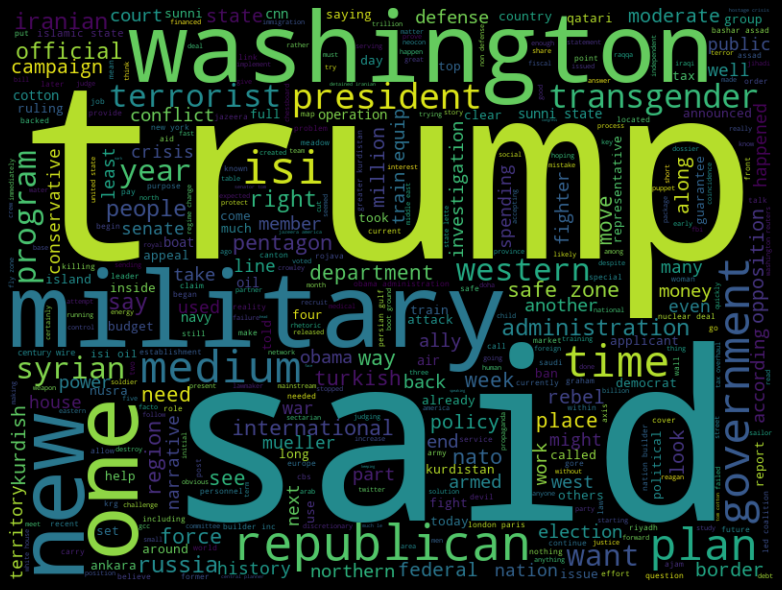

In [272]:
# WordCloud after preprocessing
plot_word_cloud(data, 'category', 'text', 0)

The above WordCloud makes it evident that trump, washington, military, said, government are trending topics in fake news

Real News Word Cloud (After Preprocessing)

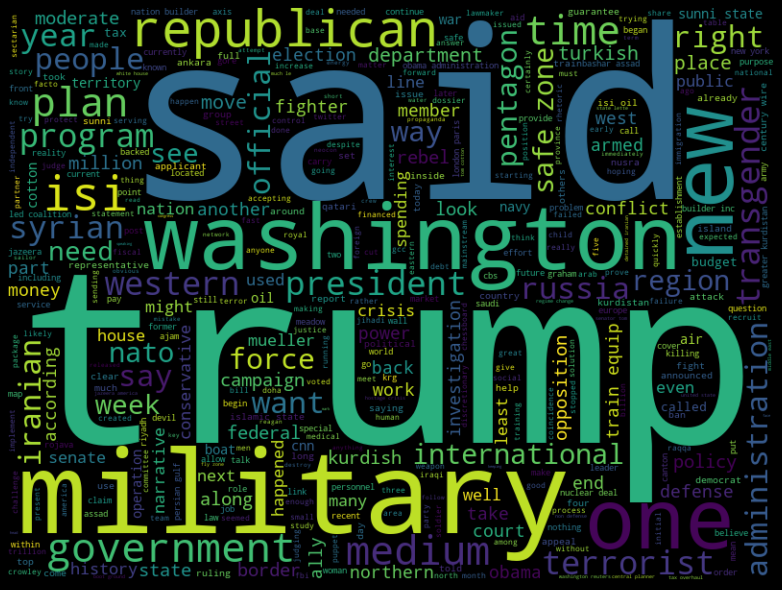

In [273]:
# WordCloud after preprocessing
plot_word_cloud(data, 'category', 'text', 1)

On the other hand, washington, military, trump, said, new, one were the common words in real news

### 4.2 Train Models

#### 4.2.1 Splitting the dataset

In [274]:
X = data['text']
y = data['category']

# Split the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### 4.2.2 Vectorization

In [275]:
# Declaring a Vectoriser
tfidf_vect = TfidfVectorizer()

# 'Fitting' the Vectoriser
tfidf_vect_fit = tfidf_vect.fit(X_train)

# Creating 'Test' and 'Train' vectorised dataframes
tfidf_train = tfidf_vect_fit.transform(X_train)
tfidf_test = tfidf_vect_fit.transform(X_test)

# Checking, if we did everything alright
tfidf_train

<31282x79106 sparse matrix of type '<class 'numpy.float64'>'
	with 4727149 stored elements in Compressed Sparse Row format>

In [276]:
# Define function to get evaluation scores and plot a confusion matrix
def score_model(model, y_test_true, X_test):
    """ A function that returns scores of a model as well as a confusion matrix"""
    
    y_pred = model.predict(X_test)
    
    precision, recall, fscore, train_support = score(y_test_true, y_pred, pos_label=1, average='binary')
    print('Precision: {} / Recall: {} / F1-Score: {} / Accuracy: {}'.format(
    round(precision, 3), round(recall, 3), round(fscore,3), round(accuracy_score(y_test_true,y_pred), 3)))
    
    # Create a confusion matrix 
    cm = confusion_matrix(y_test_true, y_pred)

    # Make a Dataframe, of the metrics with classes
    class_label = [0, 1]
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)

    # Plot the Model
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### 4.2.3 Simple Models

##### 4.2.3.1 Logistic Regression

Precision: 0.982 / Recall: 0.983 / F1-Score: 0.982 / Accuracy: 0.983


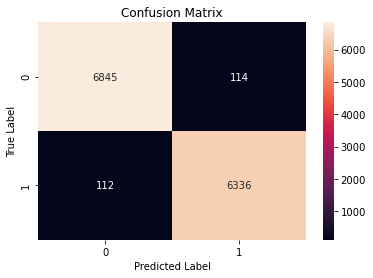

In [277]:
# Instantiate the Logistic Regression Algorithm  
lr = LogisticRegression()

# Fit Algorithm
lr.fit(tfidf_train, y_train)

score_model(lr, y_test, tfidf_test)

The accuracy of the logistic regression model implies that 98.3% of the time, the model correctly classifies a news article as true or fake.

The precision and recall scores are 98.2 % and 98.3% respectively. Implying that out of the total real news, 98.2 % were truly real.

112 samples were classified as fake yet they were true. On the other hand, 114 samples were classified as true yet they were false.

6336 samples were correctly classified correctly.

##### 4.2.3.2 Random Forest Algorithm

Precision: 0.98 / Recall: 0.982 / F1-Score: 0.981 / Accuracy: 0.982


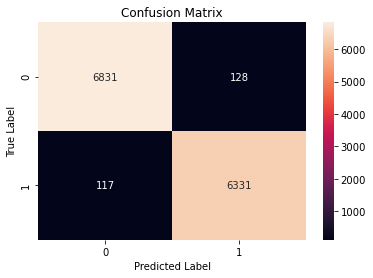

In [278]:
# Instantiate the Naive Bayes Algorithm# 
rf = RandomForestClassifier(min_samples_leaf=20, min_samples_split=20, random_state=100)

# Fit Algorithm
rf = rf.fit(tfidf_train , y_train)

score_model(rf, y_test, tfidf_test)

The random forest model performs slightly worse than the logistic regression model with an accuracy score of 98.2%. 

98% of the time, a news article is correctly classified as real or fake. 

The precision and recall scores are 98% and 98.2% respectively. Implying that out of the total real news, 98% were truly real. 117 samples were classified as fake yet they were true. 

On the other hand, 128 samples were classified as true yet they were false. 6331 samples were correctly classified correctly.

### 4.3 Advanced ML Models

#### 4.3.1 Ada Boosting Classifier

Precision: 0.994 / Recall: 0.996 / F1-Score: 0.995 / Accuracy: 0.995


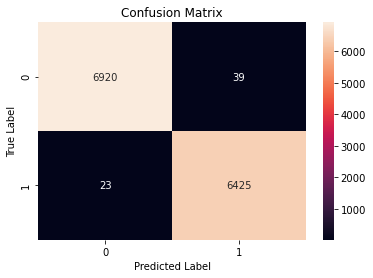

In [279]:
# Instantiating an AdaBoost Classifier
ada_boost = AdaBoostClassifier()

# Fitting the model on the training data
ada_boost.fit(tfidf_train, y_train)

# scoring the adaboost model
score_model(ada_boost, y_test, tfidf_test)

The Ada Boosting model performs better than the logistic regression and random forest models with an accuracy score of 99.5%. This can be attributed to the fact that it is able to capture more non-linear relationships in the data. This implies that a news article is correctly classified 99.5% of the time. 

The precision and recall scores are 99.4% and 99.6%. This implies that out of the total real news, 99.4% were truly real.

23 samples were classified as fake yet they were true. On the other hand, 39 samples were classified as true yet they were false.

6425 samples were correctly classified correctly.

#### 4.3.2 Gradient Boosting Classifier

Precision: 0.991 / Recall: 0.997 / F1-Score: 0.994 / Accuracy: 0.994


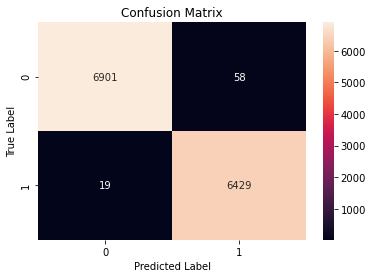

In [280]:
# Instantiating a Gradient Boosting Classifier
grad_boost = GradientBoostingClassifier()

# Fiiting to train set
grad_boost.fit(tfidf_train, y_train)

# Scoring the gradient boosting classifier
score_model(grad_boost, y_test, tfidf_test)

The Gradient Boosting model performs slightly better than the Ada Boosting model with an accuracy score of 99.4%. This implies that a news article is correctly classified 99.4% of the time.

The precision and recall scores are 99.1 % and 99.7 %. This implies that out of the total real news, 99.1 % were truly real.

19 samples were classified as fake yet they were true. On the other hand, 58 samples were classified as true yet they were false.

6429 samples were correctly classified correctly.

#### 4.3.3 XG Boosting Classifier

Precision: 0.996 / Recall: 0.998 / F1-Score: 0.997 / Accuracy: 0.997


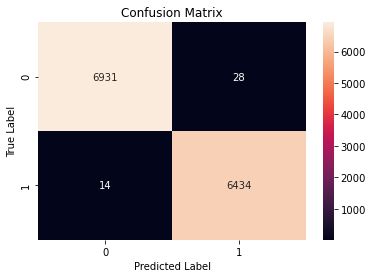

In [281]:
# Instantiating a class of XG Boost
xg_boost = XGBClassifier()

# Fitting on training data
xg_boost.fit(tfidf_train, y_train)

# scoring the XG Boost Classifier
score_model(xg_boost, y_test, tfidf_test)

The XG Boost model performs better than the other models with an accuracy score of 99.7 %. This implies that a news article is correctly classified 99.7 % of the time.

The precision and recall scores are 99.6 % and 99.8 % respectively. This implies that out of the total real news, 99.6 % are truly real.

14 samples were classified as fake yet they were true. On the other hand, 28 samples were classified as true yet they were false.

6434 samples were correctly classified correctly.

### 4.4 ROC Curves

In [282]:

# Creating a class that generates tpr and fpr for Area under the curve from ROC
class get_roc(object):
    """ A function that gets the roc values"""

    def train_rates(model, feature_train, target_train):
        """ A fucntion that gets the true positive rate, false positive rate and the thresholds"""
        
        # Calculate the fpr, tpr, and thresholds for the training set
        model_y_train_score = model.decision_function(feature_train)
        
        # Calculate the probability scores of each point in the train set
        model_train_fpr, model_train_tpr, model_thresholds = roc_curve(target_train, model_y_train_score)
        
        # Seaborn's beautiful styling
        sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

        # ROC curve for training set
        plt.figure(figsize=(10, 8))
        lw = 2
        plt.plot(model_train_fpr, model_train_tpr, color='darkorange',
                lw=lw, label='ROC curve')
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.yticks([i/20.0 for i in range(21)])
        plt.xticks([i/20.0 for i in range(21)])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
        plt.legend(loc='lower right')
        print('Training AUC: {}'.format(auc(model_train_fpr, model_train_tpr)))
        plt.show()
        
    def test_rates (model, feature_test, target_test):
        """ A fucntion that gets the true positive rate, false positive rate and the thresholds"""
        model_y_test_score = lr.decision_function(feature_test)
        
        # Calculate the fpr, tpr, and thresholds for the test set
        model_test_fpr, model_test_tpr, model_test_thresholds = roc_curve(target_test, model_y_test_score)
        
        # Seaborn's beautiful styling
        sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

        # ROC curve for training set
        plt.figure(figsize=(10, 8))
        lw = 2
        plt.plot(model_test_fpr, model_test_tpr, color='darkorange',
                lw=lw, label='ROC curve')
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.yticks([i/20.0 for i in range(21)])
        plt.xticks([i/20.0 for i in range(21)])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
        plt.legend(loc='lower right')
        print('Testing AUC: {}'.format(auc(model_test_fpr, model_test_tpr)))
        plt.show()
        
    def combined_rates(model, feature_train, feature_test, target_train, target_test):
        """ A function that gets the roc curves of both train and test in one plot"""
        model_y_train_score = model.decision_function(feature_train)
        
        # Calculate the probability scores of each point in the train set
        model_train_fpr, model_train_tpr, model_thresholds = roc_curve(target_train, model_y_train_score)
        
        # Calculate the probability scores of each point in the test set
        model_y_test_score = lr.decision_function(feature_test)
        
        # Calculate the fpr, tpr, and thresholds for the test set
        model_test_fpr, model_test_tpr, model_test_thresholds = roc_curve(target_test, model_y_test_score)
        
        print('Model Test AUC: {}'.format(auc(model_test_fpr, model_test_tpr)))
        print('Model Train AUC: {}'.format(auc(model_train_fpr, model_train_tpr)))
        
        plt.figure(figsize=(10,8))
        lw = 2
        
        plt.plot(model_test_fpr, model_test_tpr, color='darkorange',
         lw=lw, label='Model Test ROC curve')
        plt.plot(model_train_fpr, model_train_tpr, color='blue',
         lw=lw, label='Model Train ROC curve')
        
        # Formatting
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.yticks([i/20.0 for i in range(21)])
        plt.xticks([i/20.0 for i in range(21)])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()
        
    def get_auc(model, feature_train, feature_test, target_train, target_test):
        """ A function that gets the roc curves of both train and test in one plot"""
        model_y_train_score = model.decision_function(feature_train)
        
        # Calculate the probability scores of each point in the train set
        model_train_fpr, model_train_tpr, model_thresholds = roc_curve(target_train, model_y_train_score)
        
        # Calculate the probability scores of each point in the test set
        model_y_test_score = lr.decision_function(feature_test)
        
        # Calculate the fpr, tpr, and thresholds for the test set
        model_test_fpr, model_test_tpr, model_test_thresholds = roc_curve(target_test, model_y_test_score)
        
        print('Model Test AUC: {}'.format(auc(model_test_fpr, model_test_tpr)))
        print('Model Train AUC: {}'.format(auc(model_train_fpr, model_train_tpr)))

#### 4.4.1 Logistic Regression ROC

Model Test AUC: 0.9981544018724348
Model Train AUC: 0.9991561385060419


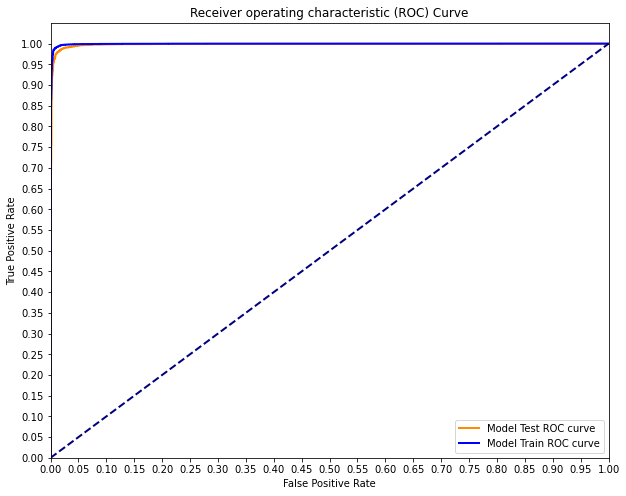

In [283]:
lr_combined = get_roc.combined_rates(lr, tfidf_train, tfidf_test, y_train, y_test)

#### 4.4.2 Random Forest ROC

The area under the curve of the random forest is 0.9981389801021724


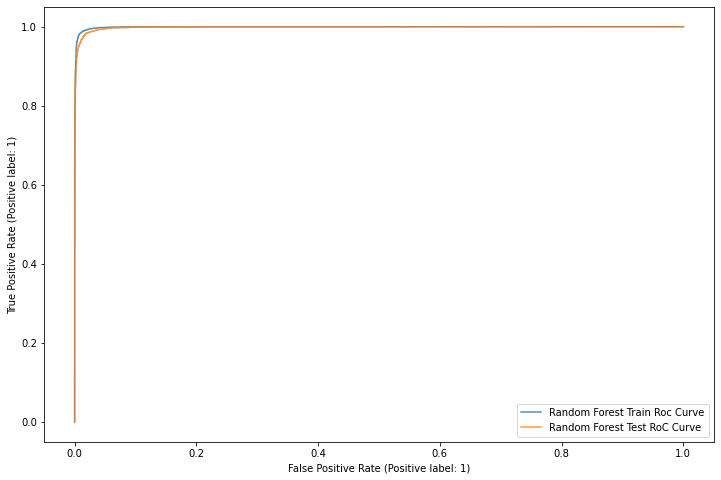

In [284]:
print(f"The area under the curve of the random forest is {roc_auc_score(y_test, rf.predict_proba(tfidf_test)[:,1])}")
# Plotting ROC curve for Random Forest
fig, ax = plt.subplots(figsize=(12,8))
ax = plt.gca()
rf_train = RocCurveDisplay.from_estimator(rf, tfidf_train, y_train, ax=ax, alpha=0.8, label ='Random Forest Train Roc Curve')
rf_disp = RocCurveDisplay.from_estimator(rf, tfidf_test, y_test, ax=ax, alpha=0.8, label= 'Random Forest Test RoC Curve')
plt.show()

#### 4.4.3 Ada Boosting Classifier ROC

In [285]:
print(f"The area under the curve of the Ada Boosting classifier is {roc_auc_score(y_test, ada_boost.predict_proba(tfidf_test)[:,1])}")

The area under the curve of the Ada Boosting classifier is 0.9993908623604331


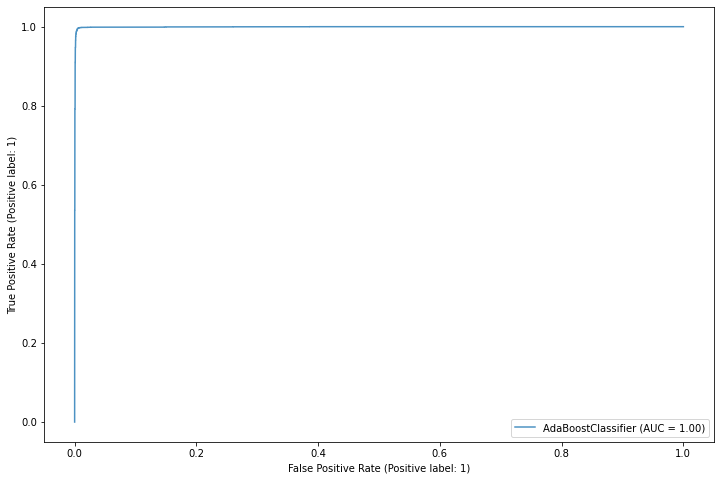

In [286]:
# Plotting ROC curve for Ada Boosting Classifier
fig, ax = plt.subplots(figsize=(12,8))
ax = plt.gca()
ada_disp = RocCurveDisplay.from_estimator(ada_boost, tfidf_test, y_test, ax=ax, alpha=0.8)
plt.show()

#### 4.4.4 Gradient Boosting Classifier ROC

In [287]:
print(f"The area under the curve of the gradient boosting classifier is {roc_auc_score(y_test, grad_boost.predict_proba(tfidf_test)[:,1])}")

The area under the curve of the gradient boosting classifier is 0.9987006601409105


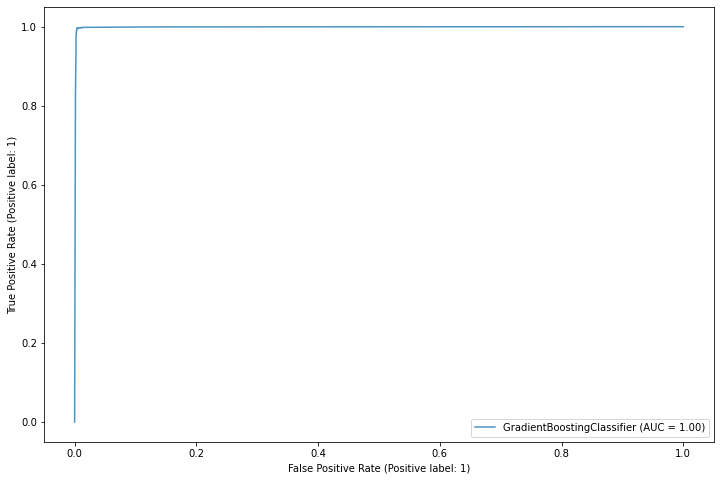

In [288]:
# Plotting ROC curve for Gradient Boosting Classifier
fig, ax = plt.subplots(figsize=(12,8))
ax = plt.gca()
grad_disp = RocCurveDisplay.from_estimator(grad_boost, tfidf_test, y_test, ax=ax, alpha=0.8)
plt.show()

#### 4.4.5 XG Boosting Classifier ROC

In [289]:
print(f"The area under the curve of the XG Boost is {roc_auc_score(y_test, xg_boost.predict_proba(tfidf_test)[:,1])}")

The area under the curve of the XG Boost is 0.9997360693277214


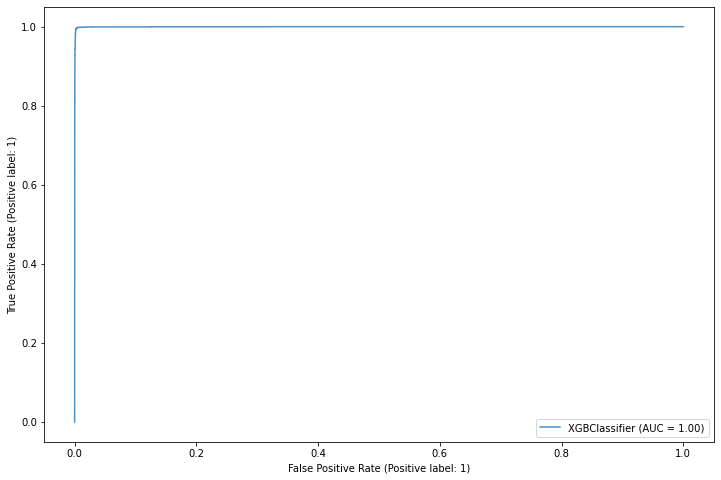

In [290]:
# Plotting ROC curve for XG Boosting Classifier
fig, ax = plt.subplots(figsize=(12,8))
ax = plt.gca()
xg_disp = RocCurveDisplay.from_estimator(xg_boost, tfidf_test, y_test, ax=ax, alpha=0.8)
plt.show()

### 4.5 Summary Table

In [291]:
# A class that gets scores
class get_scores(object):
    """ a class that gets the scores from a model"""
    def acc(model, x, y):
        """ A function that gets the accuracy score"""
        y_pred = model.predict(x)
        score = accuracy_score(y, y_pred)
        return score
    
    def precision (model, x, y):
        """ A function that gets the precision scores"""
        return precision_score(y, model.predict(x))
    
    def recall(model, x, y):
        """ A function that gets the recall scores"""
        return recall_score(y, model.predict(x))
    
    def f1 (model, x, y):
        """ A function that that gets the f1 scores"""
        return f1_score(y, model.predict(x))
    

In [292]:
# Creating instances of get_scores class
lr_scores  = get_scores
rf_scores = get_scores
gb_score = get_scores
ada_score = get_scores
xg_score = get_scores


####  4.5.1 Train Summary Table

In [293]:
# train summary table
train_summary_table = pd.DataFrame({'Model': [],
                              'Accuracy': [], 
                              'Precision': [], 'Recall': [], 'F1 Score': [],
                              })

In [294]:
# train summary
train_summary_table.loc[0] = ["Logistic Regression",
                         lr_scores.acc(lr, tfidf_train, y_train),
                         lr_scores.precision(lr, tfidf_train, y_train),
                         lr_scores.recall(lr, tfidf_train, y_train),
                         lr_scores.f1(lr, tfidf_train, y_train)]

train_summary_table.loc[2] = ["Random Forest",
                        rf_scores.acc(rf, tfidf_train, y_train),
                        rf_scores.precision(rf, tfidf_train, y_train),
                        rf_scores.recall(rf, tfidf_train, y_train),
                        rf_scores.f1(rf, tfidf_train, y_train)]

train_summary_table.loc[2] = ["Gradient Boost",
                        gb_score.acc(grad_boost, tfidf_train, y_train),
                        gb_score.precision(grad_boost, tfidf_train, y_train),
                        gb_score.recall(grad_boost, tfidf_train, y_train),
                        gb_score.f1(grad_boost, tfidf_train, y_train)]

train_summary_table.loc[3] = ["Ada Boosting Classifier",
                        ada_score.acc(ada_boost, tfidf_train, y_train),
                        ada_score.precision(ada_boost, tfidf_train, y_train),
                        ada_score.recall(ada_boost, tfidf_train, y_train),
                        ada_score.f1(ada_boost, tfidf_train, y_train)]

train_summary_table.loc[4] = ["XG Boosting Classifier",
                        xg_score.acc(xg_boost, tfidf_train, y_train),
                        xg_score.precision(xg_boost, tfidf_train, y_train),
                        xg_score.recall(xg_boost, tfidf_train, y_train),
                        xg_score.f1(xg_boost, tfidf_train, y_train)]

In [295]:
# showing the train summary table
train_summary_table

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.990154,0.987718,0.991465,0.989588
2,Gradient Boost,0.997027,0.995207,0.998510,0.996855
3,Ada Boosting Classifier,0.996867,0.995942,0.997426,0.996683
4,XG Boosting Classifier,0.999968,1.000000,0.999932,0.999966


####  4.5.2 Test Summary Table

In [296]:
# test summary table
#summary table
test_summary_table = pd.DataFrame({'Model': [],
                              'Accuracy': [], 
                              'Precision': [], 'Recall': [], 'F1 Score': [],
                              })

test_summary_table.loc[0] = ["Logistic Regression",
                         lr_scores.acc(lr, tfidf_test, y_test),
                         lr_scores.precision(lr, tfidf_test, y_test),
                         lr_scores.recall(lr, tfidf_test, y_test),
                         lr_scores.f1(lr, tfidf_test, y_test)]

test_summary_table.loc[1] = ["Random Forest",
                         rf_scores.acc(rf, tfidf_test, y_test),
                         rf_scores.precision(rf, tfidf_test, y_test),
                         rf_scores.recall(rf, tfidf_test, y_test),
                         rf_scores.f1(rf, tfidf_test, y_test)]

test_summary_table.loc[2] = ["Gradient Boost",
                        gb_score.acc(grad_boost, tfidf_test, y_test),
                        gb_score.precision(grad_boost, tfidf_test, y_test),
                        gb_score.recall(grad_boost, tfidf_test, y_test),
                        gb_score.f1(grad_boost, tfidf_test, y_test)]

test_summary_table.loc[3] = ["Ada Boosting Classifier",
                        ada_score.acc(ada_boost, tfidf_test, y_test),
                        ada_score.precision(ada_boost, tfidf_test, y_test),
                        ada_score.recall(ada_boost, tfidf_test, y_test),
                        ada_score.f1(ada_boost, tfidf_test, y_test)]

test_summary_table.loc[4] = ["XG Boosting Classifier",
                        xg_score.acc(xg_boost, tfidf_test, y_test),
                        xg_score.precision(xg_boost, tfidf_test, y_test),
                        xg_score.recall(xg_boost, tfidf_test, y_test),
                        xg_score.f1(xg_boost, tfidf_test, y_test)]

# showing the test summary table
test_summary_table

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.983143,0.982326,0.982630,0.982478
1,Random Forest,0.981726,0.980183,0.981855,0.981018
2,Gradient Boost,0.994257,0.991059,0.997053,0.994047
3,Ada Boosting Classifier,0.995376,0.993967,0.996433,0.995198
4,XG Boosting Classifier,0.996867,0.995667,0.997829,0.996747


### 4.6 Cross Validation


In [297]:
# Creating a class that performs a cross validation score
class cross_v_scores(object):
    """ A class that performs cross validation"""
    def acc_score(model, x, y):
        """ A function that gets the mean cross validation accuracy"""
        mean_score = np.mean(cross_val_score(model, x, y, cv=3, scoring='accuracy'))
        return mean_score
    
    def mse(model, x, y):
        """ A function that calculates the mean squared error"""
        mean_mse = np.mean(-cross_val_score(model, x, y, cv=5, scoring="neg_mean_squared_error"))
        return mean_mse

In [298]:
lr_cv = cross_v_scores
rf_cv = cross_v_scores
ada_cv = cross_v_scores
grad_cv = cross_v_scores
xg_cv = cross_v_scores

In [299]:
# Creating a cross validation summary table
cross_validation_summary_table = pd.DataFrame({'Model': [],
                              'Accuracy': [], 
                              'mean squared error': [],
                              })

In [300]:
# logistic regression
cross_validation_summary_table.loc[0] = ["Logistic Regression",
                                         lr_cv.acc_score(lr, tfidf_test, y_test),
                                         lr_cv.mse(lr, tfidf_test, y_test)]

# random forest
cross_validation_summary_table.loc[1] = ["Random Forest",
                                         rf_cv.acc_score(rf, tfidf_test, y_test),
                                         rf_cv.mse(rf, tfidf_test, y_test)]


# XG Boost
cross_validation_summary_table.loc[4] = ["XG Boosting Classifier",
                                         xg_cv.acc_score(xg_boost, tfidf_test, y_test),
                                         xg_cv.mse(xg_boost, tfidf_test, y_test)]

# showing the table
cross_validation_summary_table


,Model,Accuracy,mean squared error
0,Logistic Regression,0.971955,0.025509
1,Random Forest,0.966808,0.033639
4,XG Boosting Classifier,0.994779,0.004848


### 5. Evaluation

We evaluated 5 different models in this project. 2 of which were simple algorithms: Logistic Regression and Random Forrest, and 3 being advanced algorithms: Ada Boosting Classifier, Gradient Boosting Classifier, and Extreme Gradient Boosting Classifier.

The accuracy and precision scores were compared above using the summary tables. Of the 5 algorithms, XGBoost returned the best accuracy of 99.7% on our test data.

With this extremely high accuracy, we chose to employ cross validation in an aim to reduce the potential overfitting. XGBoost Classifier averaged the the best accuracy (99.5%) as well as the least mean squared error (0.005). Therefore, we saw this as the best choice to adopt for binary classification.

### 6. Deployment
> In this section, we shall be building a pipeline with the text vectorizer as well as the XGBoosting Classifier. This pipeline will be important when it comes to building our ml-app

In [301]:
# Create a pipeline
pipe = Pipeline([('tfidf', TfidfVectorizer()),
                 ('xgb', XGBClassifier())])

pipe.fit(X_train, y_train)

pipe.predict(X_test)

# Pickle the pipeline
pickle.dump(pipe, open('./models/model.pkl', 'wb'))

## 7. Findings
- The common keywords in fake news are administration, trump, government, republican

- Fake news is fairly distributed throughout the year but periods following elections , campaigns, new governments see a slight surge in volume

- The most prevalent topics in fake news are politics(evidenced by common words in the word cloud like Republican, trump, obama, government) and war indicated by conflict, attack, terrorist

- Trump is the name that appears most in fake news

## 8. Limitations
- The data was only restricted to a timeframe of 2015-2018

- Most of the news articles covered USA leaving out other locations

- Our algorithms were computationally expensive

## 9. Future Work
- Build an automated fact-checking system that combines data looking at different aspects to help non-experts in classifying news.

- Use data that covers a wide range of time focusing on world news.

- Use PySpark to process data so as to reduce computation complexity

- Use twitter API to get current news

## 10.Conclusion
- Every single news has different characteristics so there is a need for a system that can check the content of the news in depth.

- The results suggested that the approach is highly favorable since the application helps in classifying fake news and identifying key features that can be used for fake news detection.

## 11.Reccommendations
- The use of the system classifier to detect whether an article posted is legitimate to avoid misinformation to the readers
- The classifier can be used to improve the accuracy and effectiveness of other fake news detection tools and systems
- The fake news classifier can be used on a large dataset of news articles to see how well it performs. This will help gain understanding on its strengths and weaknesses, and identify areas where it can be improved.
- Use the classifier on a variety of different types of news articles, including those from different sources, with different writing styles, and on different topics to help us understand how well it can can generalize to different scenarios.


